![IronHack Logo](https://s3-eu-west-1.amazonaws.com/ih-materials/uploads/upload_d5c5793015fec3be28a63c4fa3dd4d55.png)

# Final Project

## Objetivos:

### · Predicción de la recaudación de una película en base a varios parámetros, como el presupuesto, géneros, casting, entre otros.

### · Visualización de datos entre diversas características de las películas.

## Desarrollo


### Importo las librerías y métodos necesarios a lo largo del proyecto.

In [10]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
from dotenv import load_dotenv
import os
import requests
from bs4 import BeautifulSoup
from statsmodels.multivariate.pca import PCA
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
import operator
from scipy import spatial
import warnings
warnings.filterwarnings("ignore")

### Cargo los datos y hago una primera comprobación del dataframe (en adelante, "df").

In [5]:
df = pd.read_csv('tmdb_5000_movies.csv')
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


### Veo cuántos registros y columnas tiene el df.

In [6]:
df.shape

(4803, 20)

### Empieza la limpieza. Reviso cómo es la distribución de valores de la columna status.

In [7]:
df.status.value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

### Como hay solo 8 registros que no son películas ya lanzadas, me quedaré solo con las lanzadas.

In [8]:
df = df[df.status == 'Released' ]

### Elimino columnas que no me aportarán casi nada o nada a la hora de entrenar el modelo más adelante, tales como:
#### - homepage: registros de texto únicos para cada registro que claramente no aportarán nada.
#### - original_title: escogí quedarme con title, porque así los tengo normalizados en inglés y me evito símbolos de otros idiomas, y lo mantengo solo como soporte para depurar los futuros códigos, ya que al ser también único para cada registro no aportará al modelo.
#### - status: porque ya todos tienen el mismo valor.
#### - tagline, overview: son descripciones de la película que no me servirán de nada, además la columna keywords ya incluye una versión más amigable para máquinas.
#### - spoken_languages: decidí quedarme solo con el lenguaje original, ya que pueden hablarse una gran cantidad de lenguajes en cada película.

In [9]:
df.drop(['homepage','original_title', 'status','tagline','spoken_languages','overview'], axis=1, inplace=True)

### Por mera estética, ordeno las columnas, primero creando una lista para luego asignárselas al df.

In [10]:
cols = df.columns.tolist()
cols

['budget',
 'genres',
 'id',
 'keywords',
 'original_language',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'title',
 'vote_average',
 'vote_count']

In [11]:
cols2 = ['id','title','release_date','runtime','original_language','genres','production_companies',
        'production_countries','keywords','budget','vote_average','vote_count','popularity','revenue']

In [12]:
df = df[cols2]
df.head()

,id,title,release_date,runtime,original_language,genres,production_companies,production_countries,keywords,budget,vote_average,vote_count,popularity,revenue
0,19995,Avatar,2009-12-10,162.0,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",237000000,7.2,11800,150.437577,2787965087
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",300000000,6.9,4500,139.082615,961000000
2,206647,Spectre,2015-10-26,148.0,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",245000000,6.3,4466,107.376788,880674609
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",250000000,7.6,9106,112.312950,1084939099
4,49529,John Carter,2012-03-07,132.0,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",260000000,6.1,2124,43.926995,284139100


### Reviso la distribución de los valores de la columna del lenguaje de la película. La inmensa mayoría son en inglés, pero mantendré los 4 principales idiomas, mediante la función convert_lang, que convierte todos los demás en "other".

In [13]:
df.original_language.value_counts()[:4]

en    4498
fr      70
es      32
zh      27
Name: original_language, dtype: int64

In [14]:
df.original_language.value_counts()

en    4498
fr      70
es      32
zh      27
de      27
hi      19
ja      16
it      14
cn      12
ko      11
ru      11
pt       9
da       7
sv       5
nl       4
fa       4
he       3
th       3
ro       2
id       2
ta       2
ar       2
hu       1
vi       1
sl       1
no       1
tr       1
el       1
is       1
nb       1
te       1
pl       1
xx       1
af       1
cs       1
ky       1
ps       1
Name: original_language, dtype: int64

In [15]:
def convert_lang(elem):
    top_countries = df.original_language.value_counts()[:4]
    if elem not in top_countries:
        elem = 'other'
    return elem            

In [16]:
df.original_language = df.original_language.apply(convert_lang)
df.head()

,id,title,release_date,runtime,original_language,genres,production_companies,production_countries,keywords,budget,vote_average,vote_count,popularity,revenue
0,19995,Avatar,2009-12-10,162.0,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",237000000,7.2,11800,150.437577,2787965087
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",300000000,6.9,4500,139.082615,961000000
2,206647,Spectre,2015-10-26,148.0,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",245000000,6.3,4466,107.376788,880674609
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",250000000,7.6,9106,112.312950,1084939099
4,49529,John Carter,2012-03-07,132.0,en,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",260000000,6.1,2124,43.926995,284139100


In [17]:
df.original_language.value_counts()

en       4498
other     168
fr         70
es         32
zh         27
Name: original_language, dtype: int64

### Reviso cuántos registros de las columnas vote_count y popularity son 0, y como son pocos, elimino esos registros.

In [18]:
df[df.vote_count==0].vote_count.value_counts()

0    61
Name: vote_count, dtype: int64

In [19]:
df[df.popularity==0].popularity.value_counts()

0.0    1
Name: popularity, dtype: int64

In [20]:
df = df[df.vote_count!=0]

In [21]:
df = df[df.popularity!=0]

In [22]:
df.shape

(4734, 14)

### Elimino un registro en específico que no es una película sino una miniserie, que además carece de varios de los valores discriminantes.

In [23]:
df = df[df.id!=112430]

In [24]:
df.shape

(4733, 14)

### Al descubrir este valor que no es una película y podría perjudicar el modelo, decido eliminar los registros cuya "duración" sea menor de 80 minutos, o que si es menor, tengan valores para el budget y el revenue, ya que a la hora de recuperar los valores faltantes de estas dos categorías tendré que hacer web scraping en una página que se enfoca principalmente en películas.

In [25]:
df = df[(df.runtime>80) | ((df.budget!=0) & (df.revenue!=0))]

In [26]:
df.shape

(4645, 14)

### Extraigo una lista con todos los diferentes géneros para tener una idea de cuántos diferentes hay

In [27]:
def getNames(series):
    lis = []
    for x in series:
        x = json.loads(x)
        x = [z['name'] for z in x]
        for y in x:
            if y not in lis:
                lis.append(y)
    return lis

all_genres = getNames(df.genres)
all_genres

['Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Mystery',
 'History',
 'War',
 'Music',
 'Documentary',
 'Foreign',
 'TV Movie']

### Ahora limpio los datos de género ya que están dentro de un json

In [28]:
def convert_genres(elem):
    elem = json.loads(elem)
    elem = [z['name'] for z in elem]
    return elem

# def convert_genres2(elem):
#     elem = json.loads(elem)
#     res = ''
#     for z in elem:
#         res += z['name']
#     return res

# def convert_genres3(elem):
#     elem = json.loads(elem)
#     elem = [z['name'] for z in elem]
#     return set(elem)

### Aplico la función a la columna y reviso cómo quedó

In [29]:
df.genres = df.genres.apply(convert_genres)
df.head()

,id,title,release_date,runtime,original_language,genres,production_companies,production_countries,keywords,budget,vote_average,vote_count,popularity,revenue
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, Science Fiction]","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",237000000,7.2,11800,150.437577,2787965087
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",300000000,6.9,4500,139.082615,961000000
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",245000000,6.3,4466,107.376788,880674609
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",250000000,7.6,9106,112.312950,1084939099
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, Science Fiction]","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",260000000,6.1,2124,43.926995,284139100


### Más adelante tendré que hacerlo de nuevo, pero cuando estaba desarrollando el código en un principio a esta altura obtuve los dummies de los géneros

In [30]:
genres_dummies = df['genres'].str.join(sep='*').str.get_dummies(sep='*')
genres_dummies.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Reviso la cantidad de compañías de producción diferentes que hay

In [31]:
all_comps = []
for x in df.production_companies:
    if len(x)>2:
        x = json.loads(x)
        y = x[0]['name']
    
        if y not in all_comps:
                all_comps.append(y)
len(all_comps)

1257

### Como hay tantas, debido a que muchas de las grandes tienen varias ramas, decido prescindir de ellas

In [32]:
df.drop('production_companies', axis=1, inplace=True)

### Hago lo mismo con los países, para ver cuántos diferentes hay

In [33]:
all_countries = getNames(df.production_countries)
display(len(all_countries), all_countries[:10])

83

['United States of America',
 'United Kingdom',
 'Jamaica',
 'Bahamas',
 'Dominica',
 'Czech Republic',
 'Poland',
 'Slovenia',
 'New Zealand',
 'Germany']

### Como hay una cantidad aceptable, decido seguir adelante

In [34]:
df.production_countries = df.production_countries.apply(convert_genres)
df.head()

,id,title,release_date,runtime,original_language,genres,production_countries,keywords,budget,vote_average,vote_count,popularity,revenue
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, Science Fiction]","[United States of America, United Kingdom]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",237000000,7.2,11800,150.437577,2787965087
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",[United States of America],"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",300000000,6.9,4500,139.082615,961000000
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","[United Kingdom, United States of America]","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",245000000,6.3,4466,107.376788,880674609
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",[United States of America],"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",250000000,7.6,9106,112.312950,1084939099
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, Science Fiction]",[United States of America],"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",260000000,6.1,2124,43.926995,284139100


### También los convierto en dummies

In [35]:
countries_dummies = df['production_countries'].str.join(sep='*').str.get_dummies(sep='*')
countries_dummies.head()

,Afghanistan,Angola,Argentina,Aruba,Australia,Austria,Bahamas,Belgium,Bhutan,Bolivia,...,Sweden,Switzerland,Taiwan,Thailand,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States of America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Verifico cuántas keywords diferentes hay

In [36]:
all_keys = getNames(df.keywords)
display(len(all_keys), all_keys[:10])

9765

['culture clash',
 'future',
 'space war',
 'space colony',
 'society',
 'space travel',
 'futuristic',
 'romance',
 'space',
 'alien']

### Podrían ser útiles, pero incluyen muchos términos específicos, y por motivos de practicidad y falta de tiempo también prescindiré de ellas. Sin embargo, antes las guardo en un csv por si las uso en un futuro.

In [44]:
dfkey = df.copy()

In [38]:
dfkey.to_csv('dfkey.csv', index=False)


In [99]:
keyw = dfkey.keywords

In [101]:
keyw = keyw.apply(convert_genres)
keyw.head()

0    [culture clash, future, space war, space colon...
1    [ocean, drug abuse, exotic island, east india ...
2    [spy, based on novel, secret agent, sequel, mi...
3    [dc comics, crime fighter, terrorist, secret i...
4    [based on novel, mars, medallion, space travel...
Name: keywords, dtype: object

In [102]:
keyw.to_csv('keyw.csv', index=False)


In [34]:
df.drop('keywords', axis=1, inplace=True)

### Convierto la fecha de lanzamiento a tipo fecha

In [35]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.dtypes

id                               int64
title                           object
release_date            datetime64[ns]
runtime                        float64
original_language               object
genres                          object
production_countries            object
budget                           int64
vote_average                   float64
vote_count                       int64
popularity                     float64
revenue                          int64
dtype: object

In [36]:
df.head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, Science Fiction]","[United States of America, United Kingdom]",237000000,7.2,11800,150.437577,2787965087
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",[United States of America],300000000,6.9,4500,139.082615,961000000
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","[United Kingdom, United States of America]",245000000,6.3,4466,107.376788,880674609
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",[United States of America],250000000,7.6,9106,112.312950,1084939099
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, Science Fiction]",[United States of America],260000000,6.1,2124,43.926995,284139100


In [37]:
df.shape

(4645, 12)

### Compruebo la cantidad de valores a 0 que hay en las columnas budget y revenue, que son de las más importantes para mi idea inicial, hacer un modelo de predicción del revenue.

In [38]:
df[df.revenue==0].revenue.value_counts()

0    1279
Name: revenue, dtype: int64

In [39]:
df[df.revenue==0]

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue
83,79698,The Lovers,2015-02-13,109.0,en,"[Action, Adventure, Science Fiction, Romance]","[Australia, Belgium, India]",27000000,4.8,34,2.418535,0
135,7978,The Wolfman,2010-02-11,102.0,en,"[Drama, Horror, Thriller]",[United States of America],150000000,5.5,549,21.214571,0
265,10588,The Cat in the Hat,2003-11-21,82.0,en,"[Comedy, Fantasy, Family]",[United States of America],0,4.9,366,18.251129,0
309,10214,Son of the Mask,2005-02-18,94.0,en,"[Fantasy, Comedy, Family, Adventure]","[Germany, United States of America]",84000000,3.6,338,17.815595,0
376,10357,Volcano,1997-04-25,104.0,en,"[Science Fiction, Action, Drama, Thriller]",[United States of America],90000000,5.2,376,19.836124,0
406,51052,Arthur Christmas,2011-02-22,97.0,en,"[Drama, Animation, Family, Comedy]",[United States of America],0,6.7,333,19.836830,0
433,146216,RED 2,2013-07-18,116.0,en,"[Action, Comedy, Crime, Thriller]","[Canada, France, United States of America]",84000000,6.4,1526,44.343330,0
453,12096,The Pink Panther,2006-01-18,93.0,en,"[Action, Comedy, Crime, Mystery, Family]",[United States of America],0,5.6,550,25.450534,0
463,161795,Déjà Vu,1998-04-22,117.0,en,"[Romance, Drama]",[United States of America],0,8.0,1,0.605645,0
467,9822,Mighty Joe Young,1998-12-25,114.0,en,"[Action, Adventure, Family, Fantasy]",[United States of America],90000000,5.9,208,6.643778,0


In [40]:
df[df.budget==0].budget.value_counts()

0    915
Name: budget, dtype: int64

### Representan una buena parte del dataset, por lo que trataré de arreglarlo usando web scraping de la página de IMDB

### Pero antes, uso la API de TMDB para enriquecer el dataset con los nombres del director y los 3 principales actores de cada película.

In [45]:
load_dotenv(dotenv_path='.env')
SECRET_KEY = os.getenv("TOKEN")

In [47]:
id1 = str(19995)
response = requests.get('https://api.themoviedb.org/3/movie/'+id1+'/external_ids?api_key='+SECRET_KEY)
results = response.json()
display('imdb_id' in results.keys())

True

In [50]:
def get_dirs(row):
    
    id1 = str(row['id'])
    response = requests.get('https://api.themoviedb.org/3/movie/'+id1+'/credits?api_key='+SECRET_KEY)
    results = response.json()
    if 'crew' in results.keys():
        dirs = []
        for x in results['crew']:
            if x['department'] == 'Directing':
                dirs.append(x['name'])
                return dirs
        return 0
    else: return 0

df['directors'] = df.apply(get_dirs, axis=1)


In [51]:
df.head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, Science Fiction]","[United States of America, United Kingdom]",237000000,7.2,11800,150.437577,2787965087,0,[James Cameron]
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",[United States of America],300000000,6.9,4500,139.082615,961000000,0,[Gore Verbinski]
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","[United Kingdom, United States of America]",245000000,6.3,4466,107.376788,880674609,0,[Sam Mendes]
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",[United States of America],250000000,7.6,9106,112.312950,1084939099,0,[Christopher Nolan]
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, Science Fiction]",[United States of America],260000000,6.1,2124,43.926995,284139100,0,[Andrew Stanton]


In [54]:
def get_cast(row):
    
    id1 = str(row['id'])
    response = requests.get('https://api.themoviedb.org/3/movie/'+id1+'/credits?api_key='+SECRET_KEY)
    results = response.json()
    if 'cast' in results.keys():
        cast = []
        for i in range(3):
            if len(results['cast'])>i:
                cast.append(results['cast'][i]['name'])
            else: cast.append(0)
        return cast
    else: return 0

df['cast'] = df.apply(get_cast, axis=1)

In [55]:
df.head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors,cast
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, Science Fiction]","[United States of America, United Kingdom]",237000000,7.2,11800,150.437577,2787965087,0,[James Cameron],"[Sam Worthington, Zoe Saldana, Stephen Lang]"
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",[United States of America],300000000,6.9,4500,139.082615,961000000,0,[Gore Verbinski],"[Johnny Depp, Orlando Bloom, Keira Knightley]"
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","[United Kingdom, United States of America]",245000000,6.3,4466,107.376788,880674609,0,[Sam Mendes],"[Daniel Craig, Christoph Waltz, Léa Seydoux]"
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",[United States of America],250000000,7.6,9106,112.312950,1084939099,0,[Christopher Nolan],"[Christian Bale, Michael Caine, Gary Oldman]"
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, Science Fiction]",[United States of America],260000000,6.1,2124,43.926995,284139100,0,[Andrew Stanton],"[Taylor Kitsch, Lynn Collins, Samantha Morton]"


### Luego hago una función parecida para obtener el ID de IMDB de cada película para poder hacer el web scraping posterior

In [48]:
def imdb_id(row):
    if row['budget']==0 or row['revenue']==0:
        id1 = str(row['id'])
        response = requests.get('https://api.themoviedb.org/3/movie/'+id1+'/external_ids?api_key='+SECRET_KEY)
        results = response.json()
        if 'imdb_id' in results.keys():
            return results["imdb_id"]
        else: return 0
    else: return 0

df['imdb_id'] = df.apply(imdb_id, axis=1)

In [49]:
df[df.revenue==0].head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id
83,79698,The Lovers,2015-02-13,109.0,en,"[Action, Adventure, Science Fiction, Romance]","[Australia, Belgium, India]",27000000,4.8,34,2.418535,0,tt1321869
135,7978,The Wolfman,2010-02-11,102.0,en,"[Drama, Horror, Thriller]",[United States of America],150000000,5.5,549,21.214571,0,tt0780653
265,10588,The Cat in the Hat,2003-11-21,82.0,en,"[Comedy, Fantasy, Family]",[United States of America],0,4.9,366,18.251129,0,tt0312528
309,10214,Son of the Mask,2005-02-18,94.0,en,"[Fantasy, Comedy, Family, Adventure]","[Germany, United States of America]",84000000,3.6,338,17.815595,0,tt0362165
376,10357,Volcano,1997-04-25,104.0,en,"[Science Fiction, Action, Drama, Thriller]",[United States of America],90000000,5.2,376,19.836124,0,tt0120461


### Nota: en este punto empiezo a hacer "checkpoints" de los dataframes en cada paso importante que voy haciendo, para poder volver a una versión anterior en caso de hacer algo irremediable después.

### También parte de esos checkpoints son samples para probar las funciones, ya que tardan algo de tiempo.

In [ ]:
# Glosario
# df8 = df con merge genre y countries
# df7 = df con todos los dummies
# df6_4 = df después de todos los merge
# df6 = df antes de merge con dummies
# df5 = df después de get_revenue
# df4s = sample de df4
# df4 = df antes de get_revenue * ahora igual a df5
# df3 = df antes de get_budget
# df2 = sample de df    df2 = df[1000:1465].copy()

In [ ]:
df3[df3['budget']==0].budget.value_counts()

In [ ]:
df[df['budget']==0].budget.value_counts()

In [ ]:
df2 = df[1000:1465].copy()

In [58]:
df3 = df.copy()

### Aquí empiezo el web scraping, primero con una función para rellenar el budget cuando está a 0

In [59]:
def get_budget(row):
    
    id1 = row['imdb_id']
    if id1 == 0: return row['budget']
    if row['budget'] == 0:
        
        url = 'https://www.imdb.com/title/'+id1
        html = requests.get(url).content
        soup = BeautifulSoup(html)

        budget = ''
        for element in soup.find_all('div', class_="txt-block"):
            if element.text.strip('\n').startswith('Budget:$'):
                budget = int(element.text.strip('\n').lstrip('Budget:$').rstrip('\n            (estimated)').replace(',', ''))
        if budget == '':
            return 0
        else:
            return budget
    else: return row['budget']

df['budget'] = df.apply(get_budget, axis=1)

In [63]:
df4 = df.copy()

In [64]:
df4s = df4[1000:1465].copy()

### Ahora una función parecida para rellenar el revenue

In [62]:
def get_revenue(row):
    
    id1 = row['imdb_id']
    
    if row['revenue'] > 0: 
        return row['revenue']
    
    elif id1 == 0: return row['revenue']

    else:
        
        url = 'https://www.imdb.com/title/'+id1
        html = requests.get(url).content
        soup = BeautifulSoup(html)

        glob = ''
        usa = ''
        
        for element in soup.find_all('div', class_="txt-block"):
            
            if element.text.strip('\n').startswith('Gross USA: $'):
                usa = int(element.text.strip('\n').lstrip('Gross USA: $').split(' ')[0].replace(',', ''))
            
            if element.text.strip('\n').startswith('Cumulative Worldwide Gross: $'):
                glob = int(element.text.strip('\n').lstrip('Cumulative Worldwide Gross: $').split(' ')[0].replace(',', ''))
                return glob
                
        if usa != '' and usa > 0:
            return usa
        else:
            return 0
        

df['revenue'] = df.apply(get_revenue, axis=1)

In [65]:
df5 = df.copy()

### Reviso cuántas películas tienen el budget o el revenue a 0

In [66]:
df.loc[(df['budget'] == 0) | (df['revenue'] == 0)].shape


(596, 15)

### Elimino aquellas cuyo budget y revenue son ambos 0

In [67]:
df = df[(df.budget!=0) & (df.revenue!=0)]

### También me quedo solo aquellas en las que al menos uno de los dos (budget o revenue) son mayores de 1000, porque si no no tendría mucho sentido

In [68]:
df = df[(df.budget>1000) | (df.revenue>1000)]

In [40]:
dfkey = dfkey[(dfkey.budget!=0) & (dfkey.revenue!=0)]

In [41]:
dfkey = dfkey[(dfkey.budget>1000) | (dfkey.revenue>1000)]

In [42]:
dfkey.shape

(3216, 13)

In [69]:
df.shape

(4039, 15)

In [70]:
df.head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors,cast
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, Science Fiction]","[United States of America, United Kingdom]",237000000,7.2,11800,150.437577,2787965087,0,[James Cameron],"[Sam Worthington, Zoe Saldana, Stephen Lang]"
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",[United States of America],300000000,6.9,4500,139.082615,961000000,0,[Gore Verbinski],"[Johnny Depp, Orlando Bloom, Keira Knightley]"
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","[United Kingdom, United States of America]",245000000,6.3,4466,107.376788,880674609,0,[Sam Mendes],"[Daniel Craig, Christoph Waltz, Léa Seydoux]"
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",[United States of America],250000000,7.6,9106,112.312950,1084939099,0,[Christopher Nolan],"[Christian Bale, Michael Caine, Gary Oldman]"
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, Science Fiction]",[United States of America],260000000,6.1,2124,43.926995,284139100,0,[Andrew Stanton],"[Taylor Kitsch, Lynn Collins, Samantha Morton]"


In [71]:
df6 = df.copy()

## Punto de inflexión

### En el fichero llamado main2.ipynb ubicado en el mismo directorio que este fichero, intenté hacer el objetivo inicial del proyecto, un modelo que predijera el revenue en base a las demás características, pero después de muchos intentos no obtuve ningún resultado medianamente válido o decente, así que opté por otro camino; un recomendador de películas, basado en la distancia entre películas calculada con la similaridad del coseno. 

### Para calcular dicha distancia, me basé en los dummies de los directores, los actores, y los géneros, por lo que como anuncié antes, los vuelvo a calcular pero de una forma ligeramente diferente

In [133]:
directors_dummies = df6['directors'].str.get_dummies()
directors_dummies.head()

,AaronSchneider,AaronSeltzer,AbelFerrara,AdamCarolla,AdamGoldberg,AdamGreen,AdamMarcus,AdamMcKay,AdamRapp,AdamRifkin,...,XavierGens,YashChopra,YoussefDelara,ZachBraff,ZachCregger,ZackSnyder,ZakPenn,ZalBatmanglij,ZhangYimou,ÉmileGaudreault
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
cast_dummies = df6['cast'].str.join(sep='*').str.get_dummies(sep='*')
cast_dummies.head()

,0,50Cent,A.J.Cook,Aaliyah,AamirKhan,AaranThomas,AaronAbrams,AaronEckhart,AaronKwok,AaronPaul,...,ZoeSaldana,ZoeSloane,ZooeyDeschanel,ZoéFélix,ZoëBell,ZoëKravitz,ZubaidaSahar,ZuleikhaRobinson,ÓscarJaenada,ĐỗThịHảiYến
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
countries_dummies = df['production_countries'].str.join(sep='*').str.get_dummies(sep='*')
countries_dummies.head()

,Afghanistan,Angola,Argentina,Aruba,Australia,Austria,Bahamas,Belgium,Bhutan,Bosnia and Herzegovina,...,Spain,Sweden,Switzerland,Taiwan,Thailand,Tunisia,Ukraine,United Arab Emirates,United Kingdom,United States of America
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [128]:
genres_dummies = df6['genres'].str.join(sep='*').str.get_dummies(sep='*')
genres_dummies.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,ScienceFiction,TVMovie,Thriller,War,Western
0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [130]:
df6.head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors,cast
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, ScienceFiction]","['United States of America', 'United Kingdom']",237000000,7.2,11800,150.437577,2787965087,0,JamesCameron,"[SamWorthington, ZoeSaldana, StephenLang]"
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",['United States of America'],300000000,6.9,4500,139.082615,961000000,0,GoreVerbinski,"[JohnnyDepp, OrlandoBloom, KeiraKnightley]"
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","['United Kingdom', 'United States of America']",245000000,6.3,4466,107.376788,880674609,0,SamMendes,"[DanielCraig, ChristophWaltz, LéaSeydoux]"
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",['United States of America'],250000000,7.6,9106,112.312950,1084939099,0,ChristopherNolan,"[ChristianBale, MichaelCaine, GaryOldman]"
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, ScienceFiction]",['United States of America'],260000000,6.1,2124,43.926995,284139100,0,AndrewStanton,"[TaylorKitsch, LynnCollins, SamanthaMorton]"


### Para poder calcular la distancia necesito todos los dummies en un solo array, por lo que los paso a una lista para posteriormente guardarlos como una nueva columna que contendrá dichos bins

In [124]:
genres_list = genres_dummies.values.tolist()

In [129]:
genres_dummies.shape

(4039, 20)

In [117]:
dfkg = dfkey.copy()

In [118]:
dfkg['genres_bins'] = genres_list

In [119]:
dfkg.head()

,id,title,release_date,runtime,original_language,genres,production_countries,keywords,budget,vote_average,vote_count,popularity,revenue,genres_bins
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, Science Fiction]","[United States of America, United Kingdom]","[{""id"":1463, ""name"":""cultureclash""}, {""id"":296...",237000000,7.2,11800,150.437577,2787965087,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",[United States of America],"[{""id"":270, ""name"":""ocean""}, {""id"":726, ""name""...",300000000,6.9,4500,139.082615,961000000,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","[United Kingdom, United States of America]","[{""id"":470, ""name"":""spy""}, {""id"":818, ""name"":""...",245000000,6.3,4466,107.376788,880674609,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",[United States of America],"[{""id"":849, ""name"":""dccomics""}, {""id"":853, ""na...",250000000,7.6,9106,112.312950,1084939099,"[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, Science Fiction]",[United States of America],"[{""id"":818, ""name"":""basedonnovel""}, {""id"":839,...",260000000,6.1,2124,43.926995,284139100,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [76]:
# df6_1 = pd.merge(df6, genres_dummies, left_index=True, right_index=True)

# df6_2 = pd.merge(df6_1, countries_dummies, left_index=True, right_index=True)

# df6_3 = pd.merge(df6_2, directors_dummies, left_index=True, right_index=True)

# df6_4 = pd.merge(df6_3, cast_dummies, left_index=True, right_index=True)

In [80]:
df6_4.shape

(4039, 6432)

In [81]:
df = df6_4.copy()

In [82]:
df6.dtypes

id                               int64
title                           object
release_date            datetime64[ns]
runtime                        float64
original_language               object
genres                          object
production_countries            object
budget                           int64
vote_average                   float64
vote_count                       int64
popularity                     float64
revenue                          int64
imdb_id                         object
directors                       object
cast                            object
dtype: object

### Me deshago de columnas que ya no me serán de utilidad para el modelo de main2

In [83]:
df.drop(['title','original_language', 'genres','production_countries','imdb_id','directors','cast'], axis=1, inplace=True)

In [84]:
df.dtypes.head(10)

id                       int64
release_date    datetime64[ns]
runtime                float64
budget                   int64
vote_average           float64
vote_count               int64
popularity             float64
revenue                  int64
Action                   int64
Adventure                int64
dtype: object

In [85]:
df7 = df.copy()

In [86]:
df8 = df6_2.copy()

In [87]:
df = df8.copy()

In [88]:
df.drop(['title','original_language', 'genres','production_countries','imdb_id','directors','cast'], axis=1, inplace=True)

In [89]:
df8 = df.copy()

In [90]:
df8.head()

,id,release_date,runtime,budget,vote_average,vote_count,popularity,revenue,Action,Adventure,...,Spain,Sweden,Switzerland,Taiwan,Thailand,Tunisia,Ukraine,United Arab Emirates,United Kingdom,United States of America
0,19995,2009-12-10,162.0,237000000,7.2,11800,150.437577,2787965087,1,1,...,0,0,0,0,0,0,0,0,1,1
1,285,2007-05-19,169.0,300000000,6.9,4500,139.082615,961000000,1,1,...,0,0,0,0,0,0,0,0,0,1
2,206647,2015-10-26,148.0,245000000,6.3,4466,107.376788,880674609,1,1,...,0,0,0,0,0,0,0,0,1,1
3,49026,2012-07-16,165.0,250000000,7.6,9106,112.312950,1084939099,1,0,...,0,0,0,0,0,0,0,0,0,1
4,49529,2012-03-07,132.0,260000000,6.1,2124,43.926995,284139100,1,1,...,0,0,0,0,0,0,0,0,0,1


In [91]:
df9 = df8.drop('release_date', axis=1)

In [92]:
df8a = np.array(df8)
df8a.shape

(4039, 100)

In [93]:
df9a = np.array(df9)
df9a.shape

(4039, 99)

In [ ]:
# pc = PCA(df9a, ncomp=20)
# pc.factors.shape

In [ ]:
# X = df9.values
# X_std = StandardScaler().fit_transform(X)


In [ ]:
# pca = PCA(n_components=9)
# x_9d = pca.fit_transform(X_std)

In [97]:
df6.to_csv('df_sin_dummies', index=False)

In [98]:
df6_csv = pd.read_csv('df_sin_dummies')
df6_csv

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors,cast
0,19995,Avatar,2009-12-10,162.0,en,"['Action', 'Adventure', 'Fantasy', 'Science Fi...","['United States of America', 'United Kingdom']",237000000,7.2,11800,150.437577,2787965087,0,['James Cameron'],"['Sam Worthington', 'Zoe Saldana', 'Stephen La..."
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"['Adventure', 'Fantasy', 'Action']",['United States of America'],300000000,6.9,4500,139.082615,961000000,0,['Gore Verbinski'],"['Johnny Depp', 'Orlando Bloom', 'Keira Knight..."
2,206647,Spectre,2015-10-26,148.0,en,"['Action', 'Adventure', 'Crime']","['United Kingdom', 'United States of America']",245000000,6.3,4466,107.376788,880674609,0,['Sam Mendes'],"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo..."
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"['Action', 'Crime', 'Drama', 'Thriller']",['United States of America'],250000000,7.6,9106,112.312950,1084939099,0,['Christopher Nolan'],"['Christian Bale', 'Michael Caine', 'Gary Oldm..."
4,49529,John Carter,2012-03-07,132.0,en,"['Action', 'Adventure', 'Science Fiction']",['United States of America'],260000000,6.1,2124,43.926995,284139100,0,['Andrew Stanton'],"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo..."
5,559,Spider-Man 3,2007-05-01,139.0,en,"['Fantasy', 'Action', 'Adventure']",['United States of America'],258000000,5.9,3576,115.699814,890871626,0,['Sam Raimi'],"['Tobey Maguire', 'Kirsten Dunst', 'James Fran..."
6,38757,Tangled,2010-11-24,100.0,en,"['Animation', 'Family']",['United States of America'],260000000,7.4,3330,48.681969,591794936,0,['Nathan Greno'],"['Mandy Moore', 'Zachary Levi', 'Donna Murphy']"
7,99861,Avengers: Age of Ultron,2015-04-22,141.0,en,"['Action', 'Adventure', 'Science Fiction']",['United States of America'],280000000,7.3,6767,134.279229,1405403694,0,['Joss Whedon'],"['Robert Downey Jr.', 'Chris Hemsworth', 'Mark..."
8,767,Harry Potter and the Half-Blood Prince,2009-07-07,153.0,en,"['Adventure', 'Fantasy', 'Family']","['United Kingdom', 'United States of America']",250000000,7.4,5293,98.885637,933959197,0,['David Yates'],"['Daniel Radcliffe', 'Rupert Grint', 'Emma Wat..."
9,209112,Batman v Superman: Dawn of Justice,2016-03-23,151.0,en,"['Action', 'Adventure', 'Fantasy']",['United States of America'],250000000,5.7,7004,155.790452,873260194,0,['Zack Snyder'],"['Ben Affleck', 'Henry Cavill', 'Gal Gadot']"


In [99]:
df3.to_csv('df3', index=False)
df5.to_csv('df5', index=False)
df6.to_csv('df6', index=False)
df7.to_csv('df7', index=False)
df8.to_csv('df8', index=False)


### Aquí es donde empiezo a abordar el segundo enfoque del proyecto, cargando la versión del dataset en la que aún no había agregado los dummies, pero sí hecho la limpieza y enriquecimiento previos

In [15]:
df6 = pd.read_csv('df6')

In [16]:
df6.columns

Index(['id', 'title', 'release_date', 'runtime', 'original_language', 'genres',
       'production_countries', 'budget', 'vote_average', 'vote_count',
       'popularity', 'revenue', 'imdb_id', 'directors', 'cast'],
      dtype='object')

### Para hacer unas simples visualizaciones, limpio un poco los registros de géneros, directores y actores

In [17]:
df6['genres']=df6['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
df6['genres']=df6['genres'].str.split(',')

In [77]:
df6.head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors,cast
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, ScienceFiction]","['United States of America', 'United Kingdom']",237000000,7.2,11800,150.437577,2787965087,0,['James Cameron'],"['Sam Worthington', 'Zoe Saldana', 'Stephen La..."
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",['United States of America'],300000000,6.9,4500,139.082615,961000000,0,['Gore Verbinski'],"['Johnny Depp', 'Orlando Bloom', 'Keira Knight..."
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","['United Kingdom', 'United States of America']",245000000,6.3,4466,107.376788,880674609,0,['Sam Mendes'],"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo..."
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",['United States of America'],250000000,7.6,9106,112.312950,1084939099,0,['Christopher Nolan'],"['Christian Bale', 'Michael Caine', 'Gary Oldm..."
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, ScienceFiction]",['United States of America'],260000000,6.1,2124,43.926995,284139100,0,['Andrew Stanton'],"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo..."


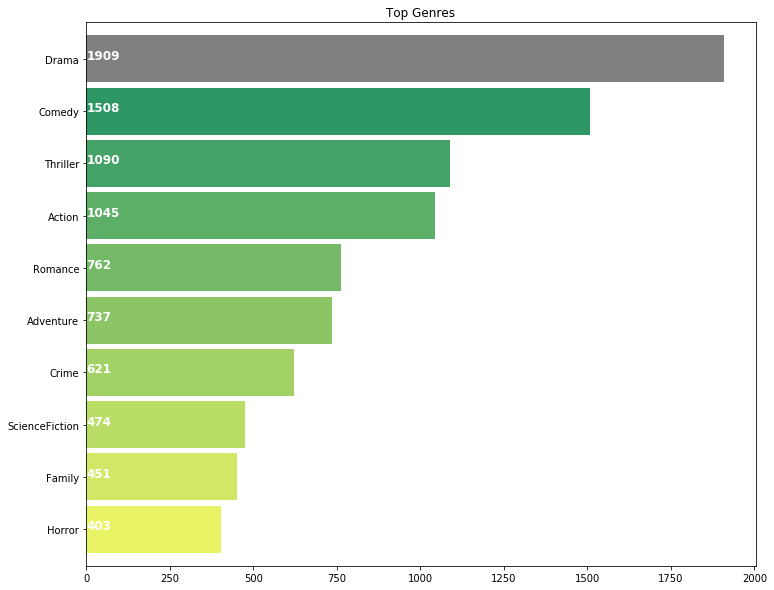

In [78]:
plt.subplots(figsize=(12,10))
list1=[]
for i in df6['genres']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('summer_r',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
ax.patches[9].set_facecolor('grey')
plt.title('Top Genres')
plt.show()

In [18]:
df6['cast']=df6['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
df6['cast']=df6['cast'].str.split(',')

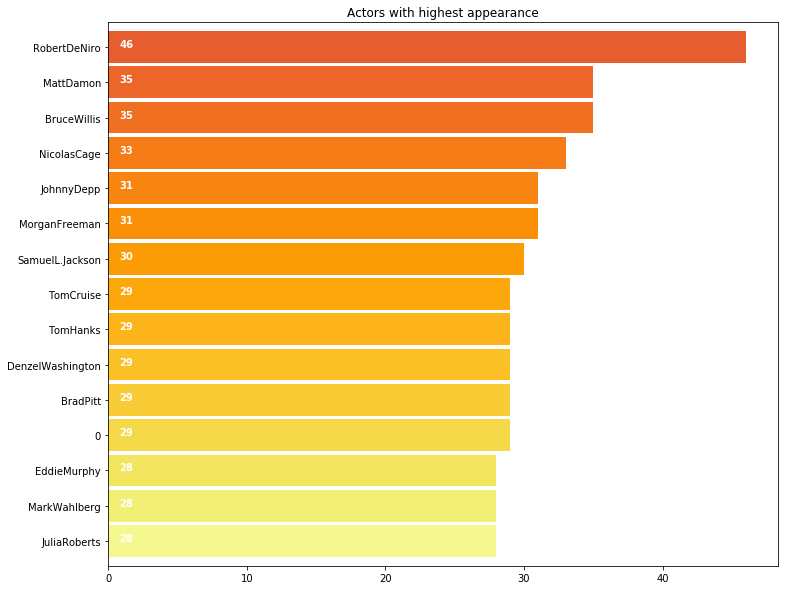

In [80]:
plt.subplots(figsize=(12,10))
list1=[]
for i in df6['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno_r',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

In [19]:
df6['directors']=df6['directors'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
df6['directors']=df6['directors'].str.split(',')

In [20]:
df6.shape

(4039, 15)

In [21]:
for i in range(4039):

    df6['directors'][i] = df6['directors'][i][0]

In [94]:
df6.head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors,cast
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, ScienceFiction]","['United States of America', 'United Kingdom']",237000000,7.2,11800,150.437577,2787965087,0,JamesCameron,"[SamWorthington, ZoeSaldana, StephenLang]"
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",['United States of America'],300000000,6.9,4500,139.082615,961000000,0,GoreVerbinski,"[JohnnyDepp, OrlandoBloom, KeiraKnightley]"
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","['United Kingdom', 'United States of America']",245000000,6.3,4466,107.376788,880674609,0,SamMendes,"[DanielCraig, ChristophWaltz, LéaSeydoux]"
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",['United States of America'],250000000,7.6,9106,112.312950,1084939099,0,ChristopherNolan,"[ChristianBale, MichaelCaine, GaryOldman]"
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, ScienceFiction]",['United States of America'],260000000,6.1,2124,43.926995,284139100,0,AndrewStanton,"[TaylorKitsch, LynnCollins, SamanthaMorton]"


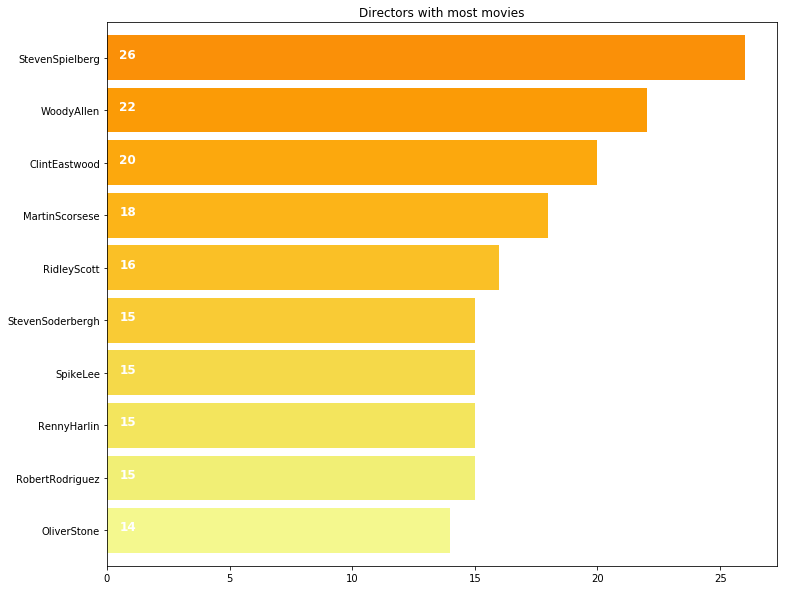

In [312]:
plt.subplots(figsize=(12,10))
ax=df6[df6['directors']!=''].directors.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.85,color=sns.color_palette('inferno_r',40))
for i, v in enumerate(df6[df6['directors']!=''].directors.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with most movies')
plt.show()

### Ahora vuelvo a hacer los dummies pero con los nuevos nombres modificados

In [22]:
directors_dummies = df6['directors'].str.get_dummies()
directors_dummies.head()

,AaronSchneider,AaronSeltzer,AbelFerrara,AdamCarolla,AdamGoldberg,AdamGreen,AdamMarcus,AdamMcKay,AdamRapp,AdamRifkin,...,XavierGens,YashChopra,YoussefDelara,ZachBraff,ZachCregger,ZackSnyder,ZakPenn,ZalBatmanglij,ZhangYimou,ÉmileGaudreault
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
cast_dummies = df6['cast'].str.join(sep='*').str.get_dummies(sep='*')
cast_dummies.head()

,0,50Cent,A.J.Cook,Aaliyah,AamirKhan,AaranThomas,AaronAbrams,AaronEckhart,AaronKwok,AaronPaul,...,ZoeSaldana,ZoeSloane,ZooeyDeschanel,ZoéFélix,ZoëBell,ZoëKravitz,ZubaidaSahar,ZuleikhaRobinson,ÓscarJaenada,ĐỗThịHảiYến
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
genres_dummies = df6['genres'].str.join(sep='*').str.get_dummies(sep='*')
genres_dummies.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,ScienceFiction,TVMovie,Thriller,War,Western
0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [25]:
df12 = df6.copy()

In [26]:
genres_list = genres_dummies.values.tolist()
cast_list = cast_dummies.values.tolist()
directors_list = directors_dummies.values.tolist()

In [27]:
df12['genres_bins'] = genres_list
df12['cast_bins'] = cast_list
df12['directors_bins'] = directors_list


### Creo la función Similarity que es la que usa la similaridad del coseno para calcular la distancia (similaridad) entre dos películas

In [11]:
def Similarity(movieId1, movieId2):
    a = df12.iloc[movieId1]
    b = df12.iloc[movieId2]
    
    genresA = a['genres_bins']
    genresB = b['genres_bins']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['cast_bins']
    scoreB = b['cast_bins']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['directors_bins']
    directB = b['directors_bins']
    directDistance = spatial.distance.cosine(directA, directB)

    return genreDistance + directDistance + scoreDistance

### Prueba de la función con dos películas en principio similares (El Padrino y El Padrino III) y arroja un buen resultado ya que mientras más cercano a 0, menos distancia hay entre las películas, y por lo tanto más se parecen

In [28]:
Similarity(3120,857)

0.8501700857389405

### Creo una nueva columna llamada new_id que contiene el índice de cada película

In [29]:
new_id=list(range(0,df12.shape[0]))
df12['new_id']=new_id

In [30]:
df12.columns

Index(['id', 'title', 'release_date', 'runtime', 'original_language', 'genres',
       'production_countries', 'budget', 'vote_average', 'vote_count',
       'popularity', 'revenue', 'imdb_id', 'directors', 'cast', 'genres_bins',
       'cast_bins', 'directors_bins', 'new_id'],
      dtype='object')

### Me quedo solo con las columnas que usaré

In [31]:
df12=df12[['title','genres','vote_average','genres_bins','cast_bins','new_id','directors','directors_bins']]

In [398]:
df12.to_csv('df12.csv', index=False)

In [3]:
df12 = pd.read_csv('df12.csv')

### Y por último, el código final del recomendador

In [5]:
def Cotufo():
    
    print('Hola, soy Cotufo. Dime parte del título de una peli que te haya gustado (en inglés, porfa):\n')
    name = input()
    
    if name != df12[df12['title'].str.contains(name)].iloc[0].to_frame().T.title.values[0]:
    
        options = []
        
        if len(df12[df12['title'].str.contains(name)]) < 10:
            for i in range(len(df12[df12['title'].str.contains(name)])):
                options.append(df12[df12['title'].str.contains(name)].iloc[i].to_frame().T.title.values[0])
        else: 
            for i in range(10):
                options.append(df12[df12['title'].str.contains(name)].iloc[i].to_frame().T.title.values[0])

        print('\nVenga, te echo una mano, ¿es una de estas?:\n')

        for o in options:
            print(o)

        print('\n')
    
        name = input()
        
        new_movie=df12[df12['title']==name].iloc[0].to_frame().T
    
    else:
    
        new_movie=df12[df12['title']==name].iloc[0].to_frame().T
    
    print('\nEn lo que tardas en leer esta frase, que para nada está puesta para hacer tiempo, te calculo las pelis más parecidas a %s, las cuales son:\n' %(new_movie.title.values[0]))
    
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in df12.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)

    for neighbor in neighbors:
        avgRating = avgRating+df12.iloc[neighbor[0]][2]  
        print( "\nTítulo: " + df12.iloc[neighbor[0]][0]+"\n\nGéneros: "+str(df12.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+"\nRating: "+str(df12.iloc[neighbor[0]][2])+'\n')
    
    print('\n')
    avgRating = avgRating/K
    print('Según mis cálculos el rating para %s es: %.2f' %(new_movie.title.values[0],avgRating))
    print('\nPero en realidad es %.2f. ¿A que no he estado tan lejos?\n\nHasta la vista, baby' %(new_movie['vote_average']))

### Luces, Cámara, Cotufo!

In [37]:
Cotufo()

Hola, soy Cotufo. Dime parte del título de una peli que te haya gustado (en inglés, porfa):

Father

Venga, te echo una mano, ¿es una de estas?:

Flags of Our Fathers
Big Mommas: Like Father, Like Son
When Did You Last See Your Father?


When Did You Last See Your Father?

En lo que tardas en leer esta frase, que para nada está puesta para hacer tiempo, te calculo las pelis más parecidas a When Did You Last See Your Father?, las cuales son:


Título: Shopgirl

Géneros: 'Comedy','Drama','Romance'
Rating: 5.7


Título: Cloud Atlas

Géneros: 'Drama','ScienceFiction'
Rating: 6.6


Título: The Railway Man

Géneros: 'Drama','History'
Rating: 6.7


Título: The King's Speech

Géneros: 'Drama','History'
Rating: 7.6


Título: Girl with a Pearl Earring

Géneros: 'Drama','Romance'
Rating: 6.4


Título: Another Year

Géneros: 'Comedy','Drama'
Rating: 7.0


Título: A Single Man

Géneros: 'Drama','Romance'
Rating: 7.3


Título: Iris

Géneros: 'Drama','Romance'
Rating: 6.2


Título: Australia

Géneros

### Algunas pruebas

In [176]:
df12[df12.title=='The Godfather']

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors,cast,genres_bins,cast_bins,directors_bins
3120,238,The Godfather,1972-03-14,175.0,en,"[Drama, Crime]",['United States of America'],6000000,8.4,5893,143.659698,245066411,0,FrancisFordCoppola,"[MarlonBrando, AlPacino, JamesCaan]","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [199]:
df12.iloc[857]

title                                       The Godfather: Part III
genres                                     [Crime, Drama, Thriller]
vote_average                                                    7.1
genres_bins       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
cast_bins         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
new_id                                                          857
directors                                        FrancisFordCoppola
directors_bins    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 857, dtype: object

In [251]:
len(df12[df12['title'].str.contains('Dragon')])

17

In [314]:
df6.head()

,id,title,release_date,runtime,original_language,genres,production_countries,budget,vote_average,vote_count,popularity,revenue,imdb_id,directors,cast
0,19995,Avatar,2009-12-10,162.0,en,"[Action, Adventure, Fantasy, ScienceFiction]","['United States of America', 'United Kingdom']",237000000,7.2,11800,150.437577,2787965087,0,JamesCameron,"[SamWorthington, ZoeSaldana, StephenLang]"
1,285,Pirates of the Caribbean: At World's End,2007-05-19,169.0,en,"[Adventure, Fantasy, Action]",['United States of America'],300000000,6.9,4500,139.082615,961000000,0,GoreVerbinski,"[JohnnyDepp, OrlandoBloom, KeiraKnightley]"
2,206647,Spectre,2015-10-26,148.0,en,"[Action, Adventure, Crime]","['United Kingdom', 'United States of America']",245000000,6.3,4466,107.376788,880674609,0,SamMendes,"[DanielCraig, ChristophWaltz, LéaSeydoux]"
3,49026,The Dark Knight Rises,2012-07-16,165.0,en,"[Action, Crime, Drama, Thriller]",['United States of America'],250000000,7.6,9106,112.312950,1084939099,0,ChristopherNolan,"[ChristianBale, MichaelCaine, GaryOldman]"
4,49529,John Carter,2012-03-07,132.0,en,"[Action, Adventure, ScienceFiction]",['United States of America'],260000000,6.1,2124,43.926995,284139100,0,AndrewStanton,"[TaylorKitsch, LynnCollins, SamanthaMorton]"


## Visualización Parte 2

### Hago un groupby para analizar cómo son las ganancias por director

In [329]:
df6_gbdr = df6.groupby('directors').sum().sort_values(by='revenue', ascending=False)
df6_gbdr.head()

,id,runtime,budget,vote_average,vote_count,popularity,revenue
directors,,,,,,,
StevenSpielberg,744082,3545.0,1657500000,182.1,59610,1296.553718,9117942245
PeterJackson,238747,1454.0,1293000000,66.0,45533,792.017366,6498642820
JamesCameron,61480,1018.0,746900000,51.3,32819,557.791802,5883569439
MichaelBay,605852,1758.0,1410000000,76.8,26845,520.982231,5832524638
ChristopherNolan,235515,1135.0,1005000000,62.4,62653,1482.985962,4227483234


### Creo la columna profit que representa la proporción entre revenue y budget

In [331]:
df6_gbdr['profit'] = df6_gbdr['revenue'] / df6_gbdr['budget']
df6_gbdr.head()

,id,runtime,budget,vote_average,vote_count,popularity,revenue,profit
directors,,,,,,,,
StevenSpielberg,744082,3545.0,1657500000,182.1,59610,1296.553718,9117942245,5.501021
PeterJackson,238747,1454.0,1293000000,66.0,45533,792.017366,6498642820,5.026019
JamesCameron,61480,1018.0,746900000,51.3,32819,557.791802,5883569439,7.877319
MichaelBay,605852,1758.0,1410000000,76.8,26845,520.982231,5832524638,4.136542
ChristopherNolan,235515,1135.0,1005000000,62.4,62653,1482.985962,4227483234,4.206451


### Pero considero que es más representativo la suma de los ingresos de todas las películas de cada director

In [354]:
df6_gbdr['profit_sum'] = df6_gbdr['revenue'] - df6_gbdr['budget']
df6_gbdr.head()

,id,runtime,budget,vote_average,vote_count,popularity,revenue,profit,profit_sum
directors,,,,,,,,,
StevenSpielberg,744082,3545.0,1657500000,182.1,59610,1296.553718,9117942245,5.501021,7460442245
PeterJackson,238747,1454.0,1293000000,66.0,45533,792.017366,6498642820,5.026019,5205642820
JamesCameron,61480,1018.0,746900000,51.3,32819,557.791802,5883569439,7.877319,5136669439
MichaelBay,605852,1758.0,1410000000,76.8,26845,520.982231,5832524638,4.136542,4422524638
ChristopherNolan,235515,1135.0,1005000000,62.4,62653,1482.985962,4227483234,4.206451,3222483234


### Ordeno el dataframe por los valores del profit_sum de forma descendente, y hago un reset_index para que los directores estén en una columna para poder hacer el gráfico

In [360]:
profit_sum = df6_gbdr.reset_index().sort_values(by='profit_sum', ascending=False)[df6_gbdr.reset_index().budget>500000]
profit_sum.head()

,directors,id,runtime,budget,vote_average,vote_count,popularity,revenue,profit,profit_sum
0,StevenSpielberg,744082,3545.0,1657500000,182.1,59610,1296.553718,9117942245,5.501021,7460442245
1,PeterJackson,238747,1454.0,1293000000,66.0,45533,792.017366,6498642820,5.026019,5205642820
2,JamesCameron,61480,1018.0,746900000,51.3,32819,557.791802,5883569439,7.877319,5136669439
3,MichaelBay,605852,1758.0,1410000000,76.8,26845,520.982231,5832524638,4.136542,4422524638
4,ChristopherNolan,235515,1135.0,1005000000,62.4,62653,1482.985962,4227483234,4.206451,3222483234


### Finalmente, el gráfico

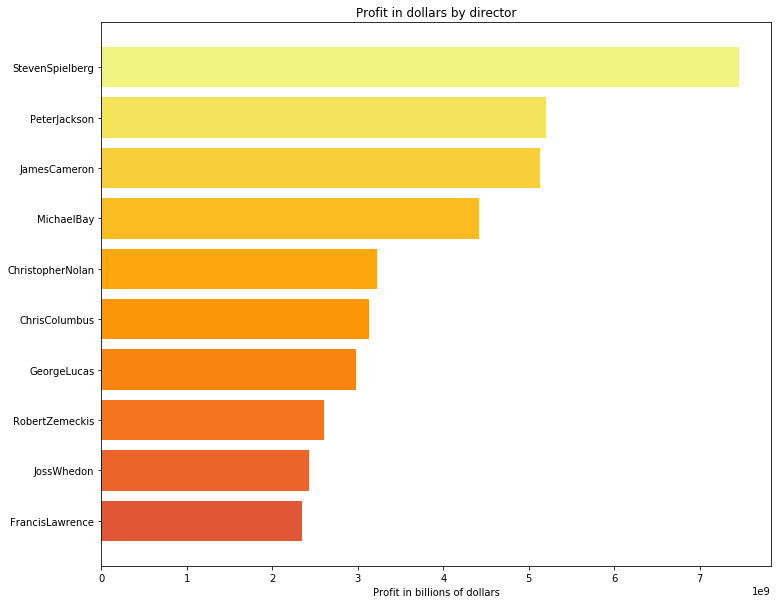

In [380]:
fig, ax = plt.subplots(figsize=(12,10))
ax.barh(profit_sum['directors'].head(10), profit_sum['profit_sum'].head(10), align='center',
        color=sns.color_palette('inferno_r',25), ecolor='black')
# ax.set_yticks(df6_gbdr.reset_index()['directors'])
# ax.set_yticklabels(df6_gbdr.reset_index()['directors'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Profit in billions of dollars')
ax.set_title('Profit in dollars by director')
plt.show()